# Koopman kernel models for TC Tracks

[Work in progress]

In [1]:
# %matplotlib inline
from climada.hazard import TCTracks
import numpy as np
from matplotlib import pyplot as plt
from itertools import product
from klearn_tcyclone.data_utils import standardize_time_series_list, concatenate_time_series_list
from kooplearn.data import TrajectoryContextDataset, TensorContextDataset

# Import dependencies

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import ml_confs
from klearn_tcyclone.data_utils import data_array_list_from_TCTracks, context_dataset_from_TCTracks
from klearn_tcyclone.data_utils import data_array_list_from_TCTracks
from random import sample

from klearn_tcyclone.testing_utils import provide_TensorContextData
import ml_confs
from sklearn.model_selection import train_test_split
from scipy.spatial.distance import pdist
from klearn_tcyclone.data_utils import characteristic_length_scale_from_TCTracks
from kooplearn.models import Kernel, NystroemKernel
from sklearn.gaussian_process.kernels import RBF
from klearn_tcyclone.performance_benchmark import timer
from klearn_tcyclone.plot_utils import plot_feature, plot_features
from klearn_tcyclone.data_utils import linear_transform, standardize_TensorContextDataset, LinearScaler

### Get data and preprocess

BASIN_ENV_PRESSURE = {
    '': DEF_ENV_PRESSURE,
    'EP': 1010, 'NA': 1010, 'SA': 1010,
    'NI': 1005, 'SI': 1005, 'WP': 1005,
    'SP': 1004,
}

In [2]:
tc_tracks = TCTracks.from_ibtracs_netcdf(provider='usa', year_range=(2000, 2021), basin='NA', correct_pres=False)
print('Number of tracks:', tc_tracks.size)

d:\work\projects\repositories\koopman_learning_tropical_cyclone\.venv\lib\site-packages\xarray\backends\plugins.py:80: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


2024-09-28 15:39:55,506 - climada.hazard.tc_tracks - WARNING - The cached IBTrACS data set dates from 2023-06-07 23:07:38 (older than 180 days). Very likely, a more recent version is available. Consider manually removing the file C:\Users\Eric\climada\data\IBTrACS.ALL.v04r00.nc and re-running this function, which will download the most recent version of the IBTrACS data set from the official URL.


d:\work\projects\repositories\koopman_learning_tropical_cyclone\.venv\lib\site-packages\climada\hazard\tc_tracks.py:614: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  if ibtracs_ds.dims['storm'] == 0:


Number of tracks: 393


In [2]:
tc_tracks = TCTracks.from_ibtracs_netcdf(provider='usa', year_range=(2000, 2001), basin='NA', correct_pres=False)
print('Number of tracks:', tc_tracks.size)

d:\work\projects\repositories\koopman_learning_tropical_cyclone\.venv\lib\site-packages\xarray\backends\plugins.py:80: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


2024-09-28 22:01:07,050 - climada.hazard.tc_tracks - WARNING - The cached IBTrACS data set dates from 2023-06-07 23:07:38 (older than 180 days). Very likely, a more recent version is available. Consider manually removing the file C:\Users\Eric\climada\data\IBTrACS.ALL.v04r00.nc and re-running this function, which will download the most recent version of the IBTrACS data set from the official URL.


d:\work\projects\repositories\koopman_learning_tropical_cyclone\.venv\lib\site-packages\climada\hazard\tc_tracks.py:614: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  if ibtracs_ds.dims['storm'] == 0:


Number of tracks: 36


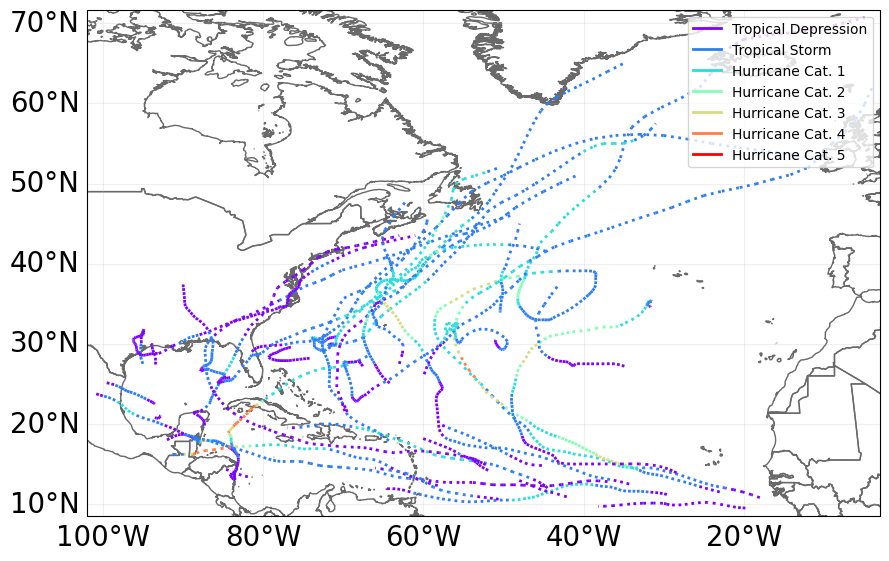

In [5]:
ax = tc_tracks.plot(linestyle="dotted")

### Normalise data

In [6]:
import xarray as xr

In [7]:
def generate_reduced_tc_tracks(tc_tracks: TCTracks)->TCTracks:
    new_xarr_list = []
    for tc_track in tc_tracks.data:
        time_data = tc_track["time"].data
        lat_data = tc_track["lat"].data
        lon_data = tc_track["lon"].data
        max_sustained_wind_data = tc_track["max_sustained_wind"].data

        data_vars = {
            # 'radius_max_wind': ('time', track_ds.rmw.data),
            # 'radius_oci': ('time', track_ds.roci.data),
            'max_sustained_wind': ('time', max_sustained_wind_data),
            # 'central_pressure': ('time', track_ds.pres.data),
            # 'environmental_pressure': ('time', track_ds.poci.data),
        }
        coords = {
            'time': ('time', time_data),
            'lat': ('time', lat_data),
            'lon': ('time', lon_data),
        }
        attrs = {
            # 'max_sustained_wind_unit': 'kn',
            # 'central_pressure_unit': 'mb',
            'orig_event_flag': True,
            # 'data_provider': provider_str,
            # 'category': category[i_track],
        }

        xarr = xr.Dataset(data_vars, coords=coords, attrs=attrs)
        # print(type(tc_track), tc_track.orig_event_flag)
        # if tc_track.orig_event_flag:
        #     xarr.orig_event_flat = True
        # else:
        #     xarr.orig_event_flat = False
        new_xarr_list.append(xarr)
        
    return TCTracks(new_xarr_list)

In [8]:
tc_tracks_reduced = generate_reduced_tc_tracks(tc_tracks)

In [9]:
len(tc_tracks_reduced.data), len(tc_tracks.data)

(36, 36)

In [10]:
# ax = tc_tracks_reduced.plot()

In [11]:
tc_tracks_train, tc_tracks_test = train_test_split(tc_tracks.data, test_size=0.1)

context_length = 42
feature_list = ["lat", "lon", "max_sustained_wind"]
# feature_list = ["lat", "lon", "max_sustained_wind", "central_pressure"]
tensor_context_train = context_dataset_from_TCTracks(
    tc_tracks_train, feature_list=feature_list, context_length=context_length
)
tensor_context_test = context_dataset_from_TCTracks(
    tc_tracks_test, feature_list=feature_list, context_length=context_length
)

contexts = {
    "train": tensor_context_train,
    "test": tensor_context_test,
}

In [12]:
tensor_context_train.shape[-1]

3

In [13]:
# scaler = StandardScaler()
scaler = LinearScaler()
# scaler = MinMaxScaler()
tensor_context_train_transformed = standardize_TensorContextDataset(
    tensor_context_train,
    scaler,
    fit=True,
)
tensor_context_test_transformed = standardize_TensorContextDataset(
    tensor_context_test,
    scaler,
    fit=False,
)

contexts = {
    "train": tensor_context_train_transformed,
    "test": tensor_context_test_transformed,
}

for split, ds in contexts.items():
    print(f"{split.capitalize()} contexts have shape {ds.shape}: {len(ds)} contexts of length {ds.context_length} with {ds.shape[2]} features each")

Train contexts have shape (656, 42, 3): 656 contexts of length 42 with 3 features each
Test contexts have shape (35, 42, 3): 35 contexts of length 42 with 3 features each


### Predict time series and plot in original coordinates

In [14]:
from klearn_tcyclone.models_utils import predict_context_shift, predict_time_series
from kooplearn.models import Kernel

In [15]:
reduced_rank = True
rank = 25
num_centers = 250
tikhonov_reg = 1e-6

# Instantiang the RBF kernel and its length scale as the median of the pairwise distances of the dataset
length_scale = characteristic_length_scale_from_TCTracks(tc_tracks_train, feature_list, quantile=0.2)
length_scale = 50.0
print("Length scale:", length_scale)
kernel = RBF(length_scale=length_scale)

Length scale: 50.0


In [16]:
# model = Kernel(kernel=kernel, reduced_rank=reduced_rank, tikhonov_reg=tikhonov_reg, rank = rank, svd_solver='arnoldi')
model = Kernel(kernel=kernel, reduced_rank=reduced_rank, svd_solver='randomized', tikhonov_reg=tikhonov_reg, rank = rank, rng_seed=42)
# model = NystroemKernel(kernel=kernel, reduced_rank=reduced_rank, svd_solver='arnoldi', tikhonov_reg=tikhonov_reg, rank = rank, num_centers=num_centers, rng_seed=42)

In [17]:
contexts['train'].shape

(656, 42, 3)

In [18]:
stop = 2500
model, fit_time = timer(model.fit)(contexts['train'][:stop])

In [19]:
from typing import Union

import numpy as np
from kooplearn.data import TensorContextDataset
from kooplearn.models import Kernel, NystroemKernel
from numpy.typing import NDArray

from klearn_tcyclone.performance_benchmark import timer
from klearn_tcyclone.models_utils import predict_time_series
from klearn_tcyclone.data_utils import TCTracks_from_TensorContextDataset


In [20]:
idx = np.random.randint(0, contexts["train"].shape[0], 10)
initial_context = contexts['train'][idx]
print(initial_context.shape)
ts = predict_time_series(model, initial_context, n_steps=13)
ts.shape

(10, 42, 3)


(10, 13, 3)

In [21]:
# #TODO The following generates TensorContextDatasets with smaller context length. This cannot be used as input to prediction for now.
# idx = np.random.randint(0, contexts["train"].shape[0])
# initial_context_arr = contexts['train'].data[:idx,:10]
# print(initial_context_arr.shape)
# print(type(initial_context_arr))
# initial_context = TensorContextDataset(initial_context_arr)
# print(initial_context.shape)
# print(type(initial_context))
# ts = predict_time_series(model, initial_context, n_steps=13)

In [22]:
type(initial_context), type(ts)

(kooplearn.data.TensorContextDataset, numpy.ndarray)

In [23]:
initial_context_back_scaled = scaler.inverse_transform(initial_context)
ts_back_scaled = scaler.inverse_transform(ts)

initial_context_tc_tracs = TCTracks_from_TensorContextDataset(initial_context_back_scaled, feature_list=feature_list)
ts_tc_tracs = TCTracks_from_TensorContextDataset(ts_back_scaled, feature_list=feature_list)

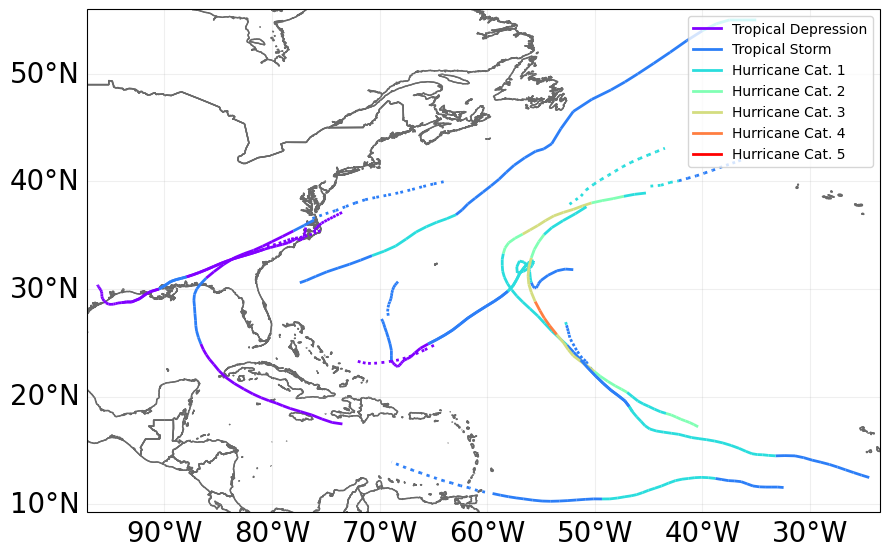

In [24]:
ax = ts_tc_tracs.plot(linestyle="dotted")
_ = initial_context_tc_tracs.plot(axis=ax, linestyle="solid")

(1, 42, 3)
(1, 13, 3)


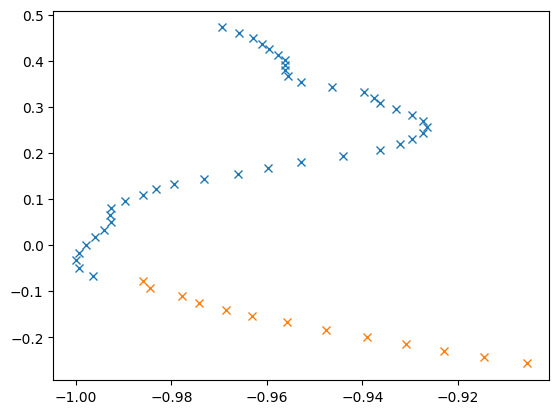

In [25]:
idx = np.random.randint(0, contexts["train"].shape[0])
initial_context = contexts['train'][idx]
print(initial_context.shape)
ts = predict_time_series(model, initial_context, n_steps=13)
print(ts.shape)
plt.plot(initial_context.data[0, :, 0], initial_context.data[0, :, 1], "x")
plt.plot(ts[0, :, 0], ts[0, :, 1], "x")

NOTE: Checkout from kooplearn._src.operator_regression.dual import predict

This function can predict for several time steps but only outputs the last one. Predicting a given context for several timesteps leads probably to something different than predicting one time step ahead, building the new context by shifting to this, and compute the next time step prediction and so on. Could be interesting to compare these two things in terms of runtime and accuracy. Predicting several time steps for given context without shift should be much faster, since only matrix multiplication needs to be applied iteratively. For this predict() needs to be slightly modified to also return intermediate results.